In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import codecs, json
from tqdm import tqdm
import numpy as np
from datetime import datetime
import time
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tracemalloc
import torch.nn as nn
import torch.optim as optim
!pip install torchmetrics
from torchmetrics import Accuracy
import sys
sys.path.append('drive/MyDrive/BmiResearch')
from constants import constants
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 48.1 MB/s eta 0:00:00


In [ ]:
def calculate_weighted_metrics(y_test, y_pred):
    """'weighted':
    Calculate metrics for each label, and find their average weighted by support
    (the number of true instances for each label). This alters ‘macro’ to account for
    label imbalance; it can result in an F-score that is not between
    precision and recall."""
    ACC = accuracy_score(y_test, y_pred)
    PPV = precision_score(y_test, y_pred, average='weighted')
    TPR = recall_score(y_test, y_pred, average='weighted')
    F1 = f1_score(y_test, y_pred, average='weighted')
    return ACC, PPV, TPR, F1


def calculate_weighted_metrics_per_class(y_test, y_pred):
    ACC = accuracy_score(y_test, y_pred)
    PPV = precision_score(y_test, y_pred, average=None)
    TPR = recall_score(y_test, y_pred, average=None)
    F1 = f1_score(y_test, y_pred, average=None)
    PPV = [round(el, 3) for el in PPV]
    TPR = [round(el, 3) for el in TPR]
    F1 = [round(el, 3) for el in F1]
    return ACC, PPV, TPR, F1


def apply_standard_scaling(data_chanks_list_train, one_scaler):
    print('[apply_standard_scaling]')
    print("data_chanks_list_train shape = ", data_chanks_list_train[0].shape)
    final_train_set = []
    for chank_df in tqdm(data_chanks_list_train):
        final_train_set.append(one_scaler.transform(chank_df.T).T)
    return np.array(final_train_set)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class EEG_LSTM(nn.Module):
    def __init__(self, input_size, num_layers, num_classes, hidden_size, fc_size, dropout):
        super(EEG_LSTM, self).__init__()

        # Define LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Define fully connected layer
        self.fc = nn.Linear(hidden_size, fc_size, bias=False)
        self.bn = nn.BatchNorm1d(fc_size)
        self.fc2 = nn.Linear(fc_size, num_classes, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass through each LSTM layer
        h1, _ = self.lstm1(x)
        h3 = F.relu(self.bn(self.fc(h1[:, -1, :])))
        h4 = self.fc2(h3)
        out = self.softmax(h4)
        return out


def train_one_epoch_lstm(model, data_loader, loss_fn, optimizer, num_classes):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=num_classes).to(device)

    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())

    return model, loss_train.avg, acc_train.compute().item()

def test_one_epoch_lstm(model, test_loader, loss_fn, num_classes):
  model.eval()
  loss_test = AverageMeter()
  acc_test = Accuracy(task="multiclass", num_classes=num_classes).to(device)

  with torch.no_grad():
      for i, (inputs, targets) in enumerate(test_loader):
          inputs = inputs.to(device)
          targets = targets.to(device)

          outputs = model(inputs)
          loss = loss_fn(outputs, targets)

          loss_test.update(loss.item())
          acc_test(outputs, targets.int())

  return loss_test.avg, acc_test.compute().item()

class_names_dict = {'RightTO': 0, 'RightHS': 1, 'LeftTO': 2, 'LeftHS': 3}

class_names_dict_1 = {0: 'RightTO',  1: 'RightHS',  2: 'LeftTO',  3: 'LeftHS'}

In [ ]:
# Define the input dimensions
input_size = 100  # Number of data points
num_classes = 4  # Number of output classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_layers = 3
train_batch_size = 256
num_epochs = 250
hidden_size = 80
fc_size = 75
dropout = 0.2

In [ ]:
constants.FEATURE_EXTRACTION

['ICA', 'CSP', 'NOFE']

In [ ]:
constants.SIGNAL_PROCESSING

['SLF', 'ASR', 'NOSP']

In [ ]:
for sp in constants.SIGNAL_PROCESSING:
  for fe in constants.FEATURE_EXTRACTION:
    output_path = f'{constants.MODELS}/lstm_rs2/{sp}_{fe}'
    print('output_path: ', output_path)

    if (sp == 'NOSP') & (fe == 'NOFE'):
      dataset_path = constants.BASE_DATASET_PATH
    elif (sp != 'NOSP') & (fe == 'NOFE'):
      dataset_path = f'{constants.PREPROCESSED_DATASET_PATH}/{sp}'
    else:
      dataset_path = f'{constants.PREPROCESSED_DATASET_PATH}/{sp}_{fe}'

    print('dataset_path: ', dataset_path)
    for subject in sorted(os.listdir(dataset_path)):

      print(subject)
      experiment_settings = dict()
      experiment_settings['general_params'] = {'low_filter':constants.low_filter,
                                              'high_filter':constants.high_filter,
                                              'frequency':constants.freq,
                                              'minutes_for_test':constants.minutes_for_test,
                                              'window_size':constants.window_size,
                                              'overlap':constants.overlap,
                                              'EEG_CHANNELS':constants.EEG_CHANNELS}
      experiment_settings['subject'] = subject
      experiment_settings['signal_processing'] = sp
      experiment_settings['feature_extraction'] = fe
      experiment_settings['classification'] = 'LSTM'
      experiment_settings['DateTime'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
      experiment_settings['dataset_path'] = dataset_path
      output_path_subject = (f'{output_path}/{subject}')
      experiment_settings['OUTPUT_PATH'] = output_path_subject
      os.makedirs(output_path_subject)

      # fit
      fit_df = codecs.open(f'{dataset_path}/{subject}/X_fit.json', 'r', encoding='utf-8').read()
      fit_df = json.loads(fit_df)
      fit_df = np.array(fit_df)

      one_scaler = StandardScaler()
      one_scaler.fit(fit_df)

      # train
      chanks_train = codecs.open(f'{dataset_path}/{subject}/X_train_chunks.json', 'r', encoding='utf-8').read()
      chanks_train = json.loads(chanks_train)
      chanks_train = np.array(chanks_train)

      # test
      chanks_test = codecs.open(f'{dataset_path}/{subject}/X_test_chunks.json', 'r', encoding='utf-8').read()
      chanks_test = json.loads(chanks_test)
      chanks_test = np.array(chanks_test)

      # y train
      final_y_train_list = codecs.open(f'{constants.BASE_DATASET_PATH}/{subject}/y_train_chunks.json', 'r', encoding='utf-8').read()
      final_y_train_list = json.loads(final_y_train_list)
      final_y_train_list = np.array(final_y_train_list)

      # y test
      final_y_test_list = codecs.open(f'{constants.BASE_DATASET_PATH}/{subject}/y_test_chunks.json', 'r', encoding='utf-8').read()
      final_y_test_list = json.loads(final_y_test_list)
      final_y_test_list = np.array(final_y_test_list)

      chanks_train = apply_standard_scaling(chanks_train, one_scaler)

      starttime = time.perf_counter()
      lstm_test_set = apply_standard_scaling(chanks_test, one_scaler)
      duration_standard_scaling_s = (time.perf_counter() - starttime)
      scale_1ch_s = round(duration_standard_scaling_s / chanks_test.shape[0], 10)
      experiment_settings['scale_1ch_s'] = scale_1ch_s

      m, n_el, n_t = chanks_train.shape
      if n_t == 33:
          chanks_train = chanks_train.reshape((m, n_t, n_el))
          lstm_test_set = lstm_test_set.reshape((lstm_test_set.shape[0], n_t, n_el))
      else:
          chanks_train = chanks_train.reshape((m, n_el, n_t))
          lstm_test_set = lstm_test_set.reshape((lstm_test_set.shape[0], n_el, n_t))

      lstm_train_set, lstm_val_set, y_train, y_val = train_test_split(chanks_train, final_y_train_list,
                                                                                  test_size=0.1,
                                                                                  random_state=42)
      dataset = TensorDataset(torch.from_numpy(lstm_train_set).float(),
                              torch.from_numpy(y_train))
      data_loader = DataLoader(dataset,
                                batch_size=train_batch_size,
                                shuffle=True)

      dataset_val = TensorDataset(torch.from_numpy(lstm_val_set).float(), torch.from_numpy(y_val))
      val_loader = DataLoader(dataset_val, train_batch_size, shuffle=True)

      torch.manual_seed(42)
      # torch.manual_seed(17)
      # torch.manual_seed(1)
      model = EEG_LSTM(input_size, num_layers, num_classes, hidden_size, fc_size, dropout).to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.NAdam(model.parameters(), lr=0.01)
      scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
      loss_train_hist = []
      loss_test_hist = []
      acc_train_hist = []
      acc_test_hist = []
      PATH_models = []

      # early_stopping
      best_score = None
      early_stop = False
      counter = 0
      patience = 20

      starttime = time.perf_counter()
      tracemalloc.start()

      epoch_num = 0
      for epoch in range(num_epochs):
        model, loss_train, acc_train = train_one_epoch_lstm(model, data_loader, loss_fn, optimizer, num_classes)
        loss_train_hist.append(loss_train)

        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        # print()

        # outputs = model(torch.from_numpy(lstm_test_set).float().to(device))
        loss_test, acc_test = test_one_epoch_lstm(model, val_loader, loss_fn, num_classes)
        loss_test_hist.append(loss_test)
        acc_train_hist.append(acc_train)
        acc_test_hist.append(acc_test)
        print("lr %.4f -> %.4f" % (before_lr, after_lr) + f' | epoch {epoch}: Train Loss= {loss_train:.4}, Train Accuracy= {int(acc_train * 100)}% | Val Loss: {loss_test:.4}, Val Accuracy: {acc_test:.4}')
        epoch_num = epoch
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        score = -loss_test

        if best_score is None:
            best_score = score
            PATH = f"{output_path_subject}/model_lstm_{sp}_{fe}_{epoch_num}.pt"
            torch.save(model, PATH)
            PATH_models.append(PATH)
        elif score < best_score: # + self.delta:
            counter += 1
            print(f'EarlyStopping counter: {counter} out of {patience}')
            if counter >= patience:
                early_stop = True
        else:
            best_score = score
            counter = 0
            PATH = f"{output_path_subject}/model_lstm_{sp}_{fe}_{epoch_num}.pt"
            torch.save(model, PATH)
            PATH_models.append(PATH)


        current, peak = tracemalloc.get_traced_memory()
        duration = round((time.perf_counter() - starttime) / 60, 3)
        print(
            f"-----current memory usage, MB [{current / (1024 * 1024):0.2f}]~peak memory usage, MB [{peak / (1024 * 1024):0.2f}]~time [{duration}] minutes \n")
        if early_stop:
          print("Early stopping")
          break

      current, peak_train_MB = tracemalloc.get_traced_memory()
      duration_train_min = round((time.perf_counter() - starttime) / 60, 3)
      # result_dict['peak_train_MB'] = round(peak_train_MB / (1024 * 1024), 2)
      # result_dict['duration_train_min'] = duration_train_min
      print(
          f"Final current memory usage, MB [{current / (1024 * 1024):0.2f}]~peak memory usage, MB [{peak_train_MB / (1024 * 1024):0.2f}]~time [{duration_train_min}] minutes, ")

      tracemalloc.reset_peak()
      tracemalloc.clear_traces()
      tracemalloc.stop()
      train_dict = {'num_epochs': epoch_num+1, 'loss_train_hist': loss_train_hist,
                    'acc_train_hist': acc_train_hist, 'loss_test_hist':loss_test_hist, 'acc_test_hist':acc_test_hist}
      # print("train_dict = ", train_dict)
      experiment_settings['train_dict'] = train_dict

      plt.plot(range(epoch_num+1), loss_train_hist, 'b-', label='Train loss')
      plt.plot(range(epoch_num+1), acc_train_hist, 'r-', label='Train Acc')
      plt.plot(range(epoch_num+1), loss_test_hist, 'g-', label='Val loss')
      plt.plot(range(epoch_num+1), acc_test_hist, 'm-', label='Val Acc')
      plt.xlabel('Epoch')
      plt.grid(True)
      plt.legend()
      plt.show()

      model = torch.load(PATH_models[-1])

      starttime = time.perf_counter()
      tracemalloc.start()

      model.eval()
      lstm_test_set_tensor = torch.from_numpy(lstm_test_set).float().to(device)

      with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(lstm_test_set_tensor).float()

      outputs_1 = np.array([np.argmax(el) for el in outputs.detach().cpu().numpy()])
      labels = unique_labels(final_y_test_list, outputs_1)
      labels = [class_names_dict_1[el] for el in labels]
      ACC_w, PPV_w, TPR_w, F1_w = calculate_weighted_metrics(final_y_test_list, outputs_1)
      ACC, PPV, TPR, F1 = calculate_weighted_metrics_per_class(final_y_test_list, outputs_1)

      current, peak_predict = tracemalloc.get_traced_memory()
      sec_predict = round((time.perf_counter() - starttime), 3)
      tracemalloc.reset_peak()
      tracemalloc.clear_traces()
      tracemalloc.stop()

      proc_1ch_s = round(sec_predict / chanks_test.shape[0], 5)
      experiment_settings['pred_1_ch_s'] = proc_1ch_s
      experiment_settings['len_test'] = chanks_test.shape[0]

      experiment_settings['y_test'] = list(final_y_test_list[:])
      experiment_settings['prediction'] = list(outputs_1[:])
      # print('Y test:', list(final_y_test_list[:]))
      # print('Prediction:', list(predictions[:]))
      experiment_settings['labels'] = labels
      cm = confusion_matrix(final_y_test_list, outputs_1, normalize='true')
      experiment_settings['confusion_matrix'] = experiment_settings['confusion_matrix'] = cm.tolist()
      print(cm)
      print("ACC_w, PPV_w, TPR_w, F1_w = ", ACC_w, PPV_w, TPR_w, F1_w)
      print("ACC, PPV, TPR, F1 = ", ACC, PPV, TPR, F1)

      experiment_settings['peak_predict_MB'] = round(peak_predict / (1024 * 1024), 2)
      experiment_settings['sec_predict'] = sec_predict
      experiment_settings['accuracy_score'] = round(ACC_w, 3)
      experiment_settings['precision_score'] = round(PPV_w, 3)
      experiment_settings['recall_score'] = round(TPR_w, 3)
      experiment_settings['f1_score'] = round(F1_w, 3)
      print("round(F1_w, 3) = ", round(F1_w, 3))

      for i, val in enumerate(labels):
          experiment_settings[f'{val}_precision_score'] = f'{round(PPV[i], 3)}'
          experiment_settings[f'{val}_recall_score'] = f'{round(TPR[i], 3)}'
          experiment_settings[f'{val}_f1_score'] = f'{round(F1[i], 3)}'

      json.dump(experiment_settings, codecs.open(f'{output_path_subject}/experiment_results.json', 'w', encoding='utf-8'),
      separators=(',', ':'),
      sort_keys=True,
      indent=4, default=str)



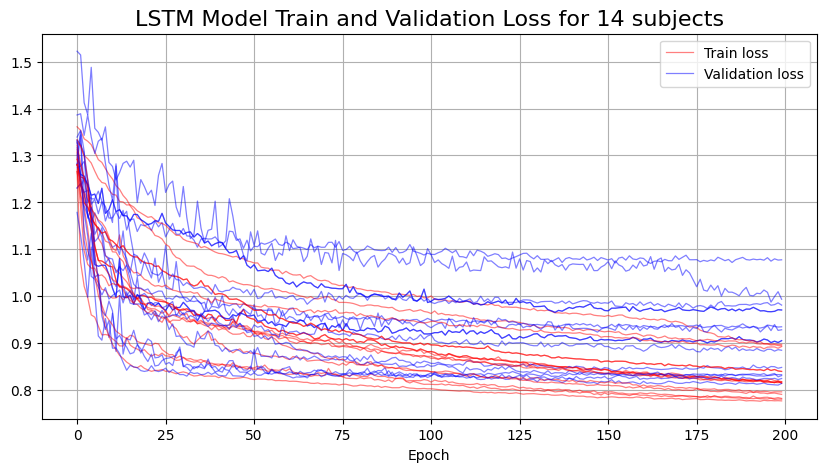

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
output_path = 'drive/MyDrive/BmiResearch/models/lstm_200/NOSP_NOFE'
for subject in sorted(os.listdir(output_path)):

  output_path_subject = f'{output_path}/{subject}'
  f = codecs.open(f'{output_path_subject}/experiment_results.json', 'r', encoding='utf-8').read()
  f = json.loads(f)
  if subject == 'sub-001':
    plt.plot(range(200), f['train_dict']['loss_train_hist'], 'r-', label='Train loss', linewidth=0.9, alpha=0.5)
    plt.plot(range(200), f['train_dict']['loss_test_hist'], 'b-', label='Validation loss', linewidth=0.9, alpha=0.5)

  plt.plot(range(200), f['train_dict']['loss_train_hist'], 'r-', linewidth=0.9, alpha=0.5)
  plt.plot(range(200), f['train_dict']['loss_test_hist'], 'b-', linewidth=0.9, alpha=0.5)

plt.xlabel('Epoch')
# plt.ylabel('Acc')
plt.grid(True)
plt.legend()
plt.title(label="LSTM Model Train and Validation Loss for 14 subjects", fontsize = 16)
plt.show()
